# Import

In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPooling1D
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical 
plt.rcParams["figure.figsize"] = (30,10)
plt.rcParams.update({'font.size': 27})

# Load Data

In [ ]:
car = pd.read_csv('/content/drive/Shareddrives/Vehicle Recognition - Sensor/Data/car-pias.csv')
bus = pd.read_csv('/content/drive/Shareddrives/Vehicle Recognition - Sensor/Data/bus-pias.csv')
bike = pd.read_csv('/content/drive/Shareddrives/Vehicle Recognition - Sensor/Data/bike-david.csv')
rail = pd.read_csv('/content/drive/Shareddrives/Vehicle Recognition - Sensor/Data/NEW RAIL/rail1b.csv')

rail_ag = rail[['ax', 'ay', 'az', 'wx', 'wy', 'wz']]
bus_ag = bus[['ax', 'ay', 'az', 'wx', 'wy', 'wz']]
bike_ag = bike[['ax', 'ay', 'az', 'wx', 'wy', 'wz']]
car_ag = car[['ax', 'ay', 'az', 'wx', 'wy', 'wz']]

# Dataset Preparation

In [ ]:
FL = 2800 # minimum of all files, the more the better. FL=20,000 is better than FL=2,000

car_ag_fl = car_ag[:FL] 
rail_ag_fl = rail_ag[:FL]
bus_ag_fl = bus_ag[:FL]
bike_ag_fl = bike_ag[:FL]

# generate class label
c0 = np.full((FL), 0).reshape(FL, 1)
c1 = np.full((FL), 1).reshape(FL, 1)
c2 = np.full((FL), 2).reshape(FL, 1)
c3 = np.full((FL), 3).reshape(FL, 1)

print(car_ag_fl.shape, rail_ag_fl.shape, bus_ag_fl.shape, bike_ag_fl.shape, c0.shape, c1.shape, c2.shape, c3.shape)

(2800, 6) (2800, 6) (2800, 6) (2800, 6) (2800, 1) (2800, 1) (2800, 1) (2800, 1)


# Simulate The Variables (David)
1.   epochs = [10, 20, 50]
2.   num_folds = [3, 5, 10]
3.   batch_size = [16, 32, 64, 512]
4.   window_size = [50, 100, 150, 200, 250, .... 500]


In [ ]:
epochs = 10
num_folds = 5
batch_size = 32
window_size = 200

# Data Preprocessing

In [ ]:

def segment_dataset(data_class, seg):
  car_np = data_class.to_numpy()
  car_seg = []
  for i in range(car_np.shape[0] - seg):
    car_seg.append(car_np[i:i+seg])
  car_seg = np.array(car_seg) 
  return car_seg


car_seg = segment_dataset(car_ag_fl, window_size)
rail_seg = segment_dataset(rail_ag_fl, window_size)
bus_seg = segment_dataset(bus_ag_fl, window_size)
bike_seg = segment_dataset(bike_ag_fl, window_size)

length = car_seg.shape[0]
# generate class label
c0 = np.full((length), 0)
c1 = np.full((length), 1)
c2 = np.full((length), 2)
c3 = np.full((length), 3)

print(car_seg.shape, c0.shape)

X = np.concatenate((car_seg, rail_seg, bus_seg, bike_seg), axis=0)

Y = np.concatenate((c0, c1, c2, c3), axis = None)
Y = to_categorical(Y)

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)
trainX.shape, testX.shape, trainY.shape, testY.shape

(2600, 200, 6) (2600,)


((8320, 200, 6), (2080, 200, 6), (8320, 4), (2080, 4))

# Set Input and Output Dimension

In [ ]:
num_classes = 4 # depends on the number of classes
input_shape = (trainX.shape[1], trainX.shape[2]) # depends on the dimension of the dataset

print(num_classes, input_shape)

4 (200, 6)


# Design 1D CNN Model

In [ ]:
def make_model(input_shape):
  #input_layer = keras.layers.Input(input_shape)
  
  input_layer = keras.layers.Input(input_shape)

  conv1 = keras.layers.Conv1D(filters=64, kernel_size=9, padding="same")(input_layer)
  conv1 = keras.layers.BatchNormalization()(conv1)
  conv1 = keras.layers.ReLU()(conv1)
  conv1 = MaxPooling1D(pool_size=(2)) (conv1)

  conv2 = keras.layers.Conv1D(filters=64, kernel_size=9, padding="same")(conv1)
  conv2 = keras.layers.BatchNormalization()(conv2)
  conv2 = keras.layers.ReLU()(conv2)
  conv2 = MaxPooling1D(pool_size=(2)) (conv2)

  conv3 = keras.layers.Conv1D(filters=64, kernel_size=9, padding="same")(conv2)
  conv3 = keras.layers.BatchNormalization()(conv3)
  conv3 = keras.layers.ReLU()(conv3)
  conv3 = MaxPooling1D(pool_size=(2)) (conv3)

  connect1 = concatenate([conv1, conv2, conv3], axis=1)


  gap = keras.layers.GlobalAveragePooling1D()(connect1)

  flat = Flatten() (gap)

  dense1 = Dense(1024, activation='relu') (flat)
  drop1 = Dropout(0.5) (dense1)

  dense2 = Dense(256, activation='relu') (drop1)
  drop2 = Dropout(0.5) (dense2)

  dense3 = Dense(64, activation='relu') (drop2)
  drop3 = Dropout(0.5) (dense3)

  output_layer = keras.layers.Dense(num_classes, activation="softmax")(dense3)

  return keras.models.Model(inputs=input_layer, outputs=output_layer)

#input_shape = (100, 6)
#num_classes = 4
model = make_model(input_shape=input_shape)
print(input_shape)
#keras.utils.plot_model(model, show_shapes=True)

(200, 6)


In [ ]:
model.save('my_model.h5')

# Experiment: KFold Validation

In [ ]:
from sklearn.model_selection import KFold

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

acc_per_fold = []
loss_per_fold = []
h_acc = {}
h_val_acc = {}

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, Y):
  model = make_model(input_shape=input_shape)
  
  model.compile(
    optimizer="adam",
    loss=keras.losses.categorical_crossentropy,
    metrics=["accuracy"],
  )
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(
    X[train],
    Y[train],
    batch_size=batch_size,
    epochs=epochs,
    validation_split = 0.2,
    verbose=1,
  )

   # Generate generalization metrics
  scores = model.evaluate(X[test], Y[test], verbose=1)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  h_acc[fold_no] = history.history['accuracy']
  h_val_acc[fold_no] = history.history['val_accuracy']

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/2
208/208 [==============================] - 15s 63ms/step - loss: 0.2498 - accuracy: 0.9081 - val_loss: 3.4926 - val_accuracy: 0.0000e+00
Epoch 2/2
65/65 [==============================] - 1s 14ms/step - loss: 0.2749 - accuracy: 0.9202
Score for fold 1: loss of 0.2749350666999817; accuracy of 92.0192301273346%
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/2
208/208 [==============================] - 14s 63ms/step - loss: 0.2212 - accuracy: 0.9150 - val_loss: 3.8488 - val_accuracy: 0.0553
Epoch 2/2
65/65 [==============================] - 1s 14ms/step - loss: 0.3427 - accuracy: 0.8779
Score for fold 2: loss of 0.34273892641067505; accuracy of 87.78846263885498%
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/2
208/208 [==============================] - 15s 64ms/step - 

# Overall Kfold Accuracy



In [ ]:
sum(acc_per_fold)/num_folds

94.03846144676208

# Save Accuracy

In [ ]:
File_name = "acc_per_fold_ws_" + str(window_size) + "_folds_" + str(num_folds) + "_batch_" + str(batch_size) + "_epochs_" + str(epochs)
acc_per_fold = np.array(acc_per_fold)
np.savetxt("/content/drive/Shareddrives/Vehicle Recognition - Sensor/Simulation/Accuracy/"+File_name + ".csv", acc_per_fold, delimiter=",")

# Visualize Training Graph

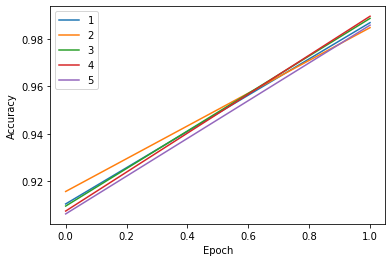

In [ ]:
acc_10 = pd.DataFrame.from_dict(h_acc)
fig = acc_10.plot(xlabel = "Epoch", ylabel = "Accuracy")
fig = fig.get_figure()
fig.savefig("/content/drive/Shareddrives/Vehicle Recognition - Sensor/Simulation/Graphs/"+File_name+'_acc.png', dpi=300)

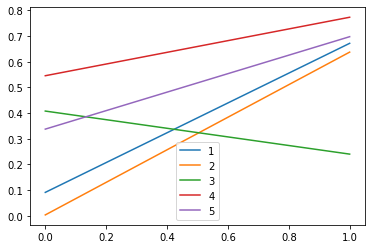

In [ ]:
val_acc_10 = pd.DataFrame.from_dict(h_val_acc)
fig = val_acc_10.plot()

fig = fig.get_figure()
fig.savefig("/content/drive/Shareddrives/Vehicle Recognition - Sensor/Simulation/Graphs/"+File_name+'_val.png', dpi=300)